<font color = blue><font size = 6> 실험설명 </font></font><br>
MyModel을 Sample3에 대해서 적용해본다

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [64]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [65]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

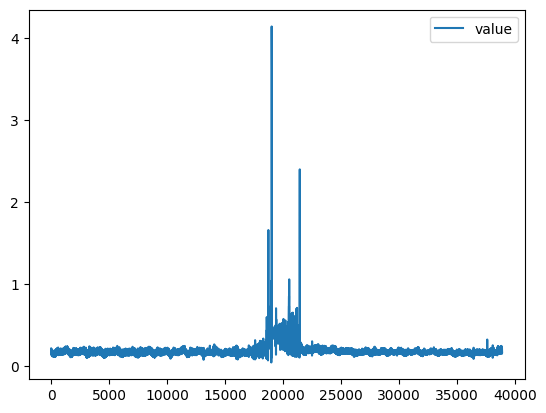

In [66]:
data.plot()

In [67]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [68]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [69]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [70]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,1,2)
        #print(new_input)
        x = self.Linear_plus(new_input)
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [71]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [72]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [73]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),6*1e-7)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [74]:
torch.manual_seed(42)

In [75]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 84.19129645266729 %
smape 83.01907247531484 %
smape 81.81848162796065 %
smape 80.56402612150761 %
smape 79.2557468470077 %
smape 77.89477985679058 %
smape 76.49392876534435 %
smape 75.08659531542084 %
smape 73.72563334933498 %
smape 72.43837967035715 %
smape 71.22067372701322 %
smape 70.07498902535578 %
smape 69.01222456704106 %
smape 68.03650480613373 %
smape 67.13020383614545 %
smape 66.26602364170272 %
smape 65.42103455821324 %
smape 64.58313881784503 %
smape 63.74893450423291 %
smape 62.916357875393146 %
smape 62.08681824873066 %
smape 61.260357281269386 %
smape 60.4390335971849 %
smape 59.62282340167558 %
smape 58.80793435183185 %
smape 58.00118216035659 %
smape 57.2058563836311 %
smape 56.42217653972364 %
smape 55.65057313320232 %
smape 54.894836963268745 %
smape 54.16133152375444 %
smape 53.45456165964143 %
smape 52.77990443228978 %
smape 52.14005313334409 %
smape 51.53193971218422 %
smape 50.95642710681896 %
smape 50.413987003484664 %
smape 49.9054445844819 %
smape 49.429

In [76]:
torch.manual_seed(42)

In [77]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [78]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)
torch.save(model,PATH+'/best_mymodel3.pt') #모델의 갱신

SMAPE 3.7211905792355537 %
SMAPE 19.213459461927414 %
SMAPE 7.436820782721043 %
SMAPE 0.04925884328608987 %
SMAPE 2.4178757425397635 %
SMAPE 2.855660254135728 %
SMAPE 7.67958327382803 %
SMAPE 0.021599879069782446 %
SMAPE 0.26952482472779593 %
SMAPE 4.888642318546772 %
SMAPE 3.0346162412315607 %
SMAPE 12.80783376842737 %
SMAPE 1.1151988683268428 %
SMAPE 6.160967469215393 %
SMAPE 6.6297371461987495 %
SMAPE 4.82272270694375 %
SMAPE 16.008706122636795 %
SMAPE 16.09251455962658 %
SMAPE 11.611428819596767 %
SMAPE 9.686919942498207 %
SMAPE 16.068900898098946 %
SMAPE 4.581493716686964 %
SMAPE 10.440306827425957 %
SMAPE 13.315342903137207 %
SMAPE 10.152844086289406 %
SMAPE 1.1960579082369804 %
SMAPE 16.41032364964485 %
SMAPE 8.885384015738964 %
SMAPE 9.384717628359795 %
SMAPE 12.553186520934103 %
SMAPE 13.088166490197182 %
SMAPE 10.382949203252792 %
SMAPE 3.7673397138714786 %
SMAPE 4.271073803305626 %
SMAPE 0.26302791738316955 %
SMAPE 4.133811809122562 %
SMAPE 11.500970549881458 %
SMAPE 6.57197

SMAPE 5.282386165112257 %
SMAPE 2.158962132409215 %
SMAPE 10.73487664014101 %
SMAPE 1.5868754880502818 %
SMAPE 3.6123038828372955 %
SMAPE 14.803787857294083 %
SMAPE 0.4409490297548473 %
SMAPE 11.074526883661747 %
SMAPE 0.9395678699947894 %
SMAPE 0.5571247258922085 %
SMAPE 2.564985003322363 %
SMAPE 3.6678554713726044 %
SMAPE 10.62774146348238 %
SMAPE 1.663120881654322 %
SMAPE 1.682862558402121 %
SMAPE 4.244476921856403 %
SMAPE 4.2575189135968685 %
SMAPE 7.012483716011047 %
SMAPE 3.7834927774965763 %
SMAPE 7.931453473865986 %
SMAPE 6.551140312105417 %
SMAPE 4.340266603976488 %
SMAPE 20.540707245469093 %
SMAPE 8.546009741723537 %
SMAPE 2.3686911538243294 %
SMAPE 4.615804772824049 %
SMAPE 3.967951260507107 %
SMAPE 4.255894720554352 %
SMAPE 1.9111617635935545 %
SMAPE 0.6088652259204537 %
SMAPE 1.9439501455053687 %
SMAPE 1.5772958565503359 %
SMAPE 13.856137096881865 %
SMAPE 2.3482566364109516 %
SMAPE 3.6495750211179256 %
SMAPE 7.878645576536655 %
SMAPE 2.6679961476475 %
SMAPE 10.642670832574

SMAPE 4.217433340847492 %
SMAPE 4.969228588044643 %
SMAPE 3.1120045594871044 %
SMAPE 5.313135053962469 %
SMAPE 2.0350604504346848 %
SMAPE 4.101390637457371 %
SMAPE 4.1155962608754635 %
SMAPE 12.896024912595749 %
SMAPE 0.5407660828204826 %
SMAPE 8.395672298967838 %
SMAPE 5.63370094448328 %
SMAPE 4.367743913084269 %
SMAPE 1.423280001617968 %
SMAPE 16.090170472860336 %
SMAPE 10.389627680182457 %
SMAPE 3.7451534792780876 %
SMAPE 4.441457778215408 %
SMAPE 13.728238478302956 %
SMAPE 0.010251926219751795 %
SMAPE 2.7709780167788267 %
SMAPE 2.5840348955243826 %
SMAPE 2.5718675144016743 %
SMAPE 2.930292772129178 %
SMAPE 3.3461605701595545 %
SMAPE 2.0189427733421326 %
SMAPE 3.1510215234011407 %
SMAPE 5.5751284919679165 %
SMAPE 8.702185161411762 %
SMAPE 6.830104008316994 %
SMAPE 4.495473012328148 %
SMAPE 2.4659085161983967 %
SMAPE 3.1671299804002047 %
SMAPE 1.1005320879630744 %
SMAPE 6.159613836556673 %
SMAPE 7.66096943616867 %
SMAPE 4.32703809812665 %
SMAPE 11.450079299509525 %
SMAPE 3.3266946524

SMAPE 3.9272290281951427 %
SMAPE 3.131139896810055 %
SMAPE 0.9518454228527843 %
SMAPE 2.043527202680707 %
SMAPE 7.336990371346473 %
SMAPE 2.25496181845665 %
SMAPE 0.970345437526703 %
SMAPE 8.173755265772343 %
SMAPE 6.552167620509863 %
SMAPE 4.275451559573412 %
SMAPE 5.981272701174021 %
SMAPE 3.902123000472784 %
SMAPE 3.1606152504682545 %
SMAPE 0.0038623087398761413 %
SMAPE 1.0182218006812036 %
SMAPE 4.678539272397757 %
SMAPE 2.0984066240489483 %
SMAPE 4.1172040440142155 %
SMAPE 3.4780658408999443 %
SMAPE 0.43785451512121654 %
SMAPE 0.0690229464162826 %
SMAPE 4.094968855381012 %
SMAPE 5.493821747601032 %
SMAPE 2.5618508737534285 %
SMAPE 3.863129861652851 %
SMAPE 1.7524459278210998 %
SMAPE 2.7994283344596624 %
SMAPE 3.901421647518873 %
SMAPE 8.353278495371342 %
SMAPE 0.7758722107391804 %
SMAPE 9.576585121452808 %
SMAPE 2.4072534162551165 %
SMAPE 3.5554600171744823 %
SMAPE 0.13032544183033679 %
SMAPE 14.380393132567407 %
SMAPE 8.98859267681837 %
SMAPE 6.767171308398247 %
SMAPE 0.302161985

SMAPE 1.023011430632323 %
SMAPE 1.175774848088622 %
SMAPE 2.3664426654577255 %
SMAPE 4.282992981374264 %
SMAPE 2.08900941722095 %
SMAPE 0.08303020634091496 %
SMAPE 4.297569077461958 %
SMAPE 0.43893101200228557 %
SMAPE 5.965747803449631 %
SMAPE 7.742096498608589 %
SMAPE 3.352840635925532 %
SMAPE 2.826150434091687 %
SMAPE 0.9732386367395519 %
SMAPE 0.06606703634236055 %
SMAPE 0.008245963767365083 %
SMAPE 0.9734590351581575 %
SMAPE 1.7409884417429566 %
SMAPE 0.022641106928631416 %
SMAPE 2.409225592389703 %
SMAPE 4.9327787682414055 %
SMAPE 0.007534496285700242 %
SMAPE 3.5819967202842236 %
SMAPE 2.757964523509145 %
SMAPE 2.6677369959652424 %
SMAPE 8.96943211555481 %
SMAPE 17.091189488768578 %
SMAPE 11.424569331109524 %
SMAPE 10.502205453813076 %
SMAPE 3.6428015567362313 %
SMAPE 12.62746498733759 %
SMAPE 3.613205913454294 %
SMAPE 7.2719459384679785 %
SMAPE 5.821026060730219 %
SMAPE 3.6011175401508804 %
SMAPE 8.919223815202713 %
SMAPE 5.496174603700638 %
SMAPE 0.5661781425587833 %
SMAPE 0.421

SMAPE 1.1944442363455892 %
SMAPE 6.2658916637301445 %
SMAPE 1.6579651925712824 %
SMAPE 0.591596917132847 %
SMAPE 4.666424468159676 %
SMAPE 0.030248704353425637 %
SMAPE 0.010647685182902933 %
SMAPE 7.009556494653226 %
SMAPE 3.708877604454756 %
SMAPE 0.41401264857267966 %
SMAPE 0.4023196753078082 %
SMAPE 3.6718512028455734 %
SMAPE 2.7098495829850435 %
SMAPE 1.655524813570082 %
SMAPE 0.7197164413519204 %
SMAPE 4.28748058155179 %
SMAPE 3.911229196935892 %
SMAPE 3.0175329111516476 %
SMAPE 15.630291759967804 %
SMAPE 8.695933192968369 %
SMAPE 1.6860645115375519 %
SMAPE 4.08328464999795 %
SMAPE 1.52061712089926 %
SMAPE 4.448971427977085 %
SMAPE 1.805369310081005 %
SMAPE 3.3656210005283356 %
SMAPE 2.1235183589160442 %
SMAPE 4.135567061603069 %
SMAPE 3.561996255069971 %
SMAPE 2.6304936204105616 %
SMAPE 4.485088229179382 %
SMAPE 12.19777975231409 %
SMAPE 3.8489425107836728 %
SMAPE 9.724759988486767 %
SMAPE 5.8496649488806725 %
SMAPE 2.5662657879292965 %
SMAPE 4.155470225960016 %
SMAPE 3.665409803

SMAPE 1.5540282800793648 %
SMAPE 1.1284234165214002 %
SMAPE 0.15484756921875942 %
SMAPE 2.7923356164246798 %
SMAPE 0.3056901547970483 %
SMAPE 0.3088555251215439 %
SMAPE 0.3846349399591418 %
SMAPE 5.136170532554388 %
SMAPE 0.26949807109303947 %
SMAPE 1.8581652715802193 %
SMAPE 18.937472850084305 %
SMAPE 15.213911056518556 %
SMAPE 17.67922866344452 %
SMAPE 0.3521834842158569 %
SMAPE 6.566312812268733 %
SMAPE 5.786131024360657 %
SMAPE 11.890072919428349 %
SMAPE 3.191645532846451 %
SMAPE 0.012627810538077712 %
SMAPE 1.6982828592881563 %
SMAPE 6.129201974719763 %
SMAPE 6.032823745161295 %
SMAPE 6.805494494736195 %
SMAPE 10.233207255601883 %
SMAPE 0.6821117112413049 %
SMAPE 3.7884860821068287 %
SMAPE 0.6888850738760084 %
SMAPE 1.3496125005185604 %
SMAPE 0.3598486436458188 %
SMAPE 0.055564459875995446 %
SMAPE 1.7643042961135507 %
SMAPE 4.882980566471815 %
SMAPE 0.8821926405653358 %
SMAPE 0.9252473278902471 %
SMAPE 3.174576837569475 %
SMAPE 0.2878391760100385 %
SMAPE 0.735620197141543 %
SMAPE 

SMAPE 3.46005423925817 %
SMAPE 0.15417231330752657 %
SMAPE 1.1373089640401304 %
SMAPE 3.3872645180672407 %
SMAPE 6.722115971148014 %
SMAPE 8.0233423858881 %
SMAPE 1.6352593880146742 %
SMAPE 0.2826280325489279 %
SMAPE 4.442200664430857 %
SMAPE 6.909788824617863 %
SMAPE 1.867219797335565 %
SMAPE 0.7039513161871582 %
SMAPE 2.4625764191150665 %
SMAPE 5.291839949786663 %
SMAPE 4.486801352351904 %
SMAPE 0.8034251588396728 %
SMAPE 9.002345100045204 %
SMAPE 1.931726049631834 %
SMAPE 1.243387145921588 %
SMAPE 1.3019633032381535 %
SMAPE 3.6808284483850007 %
SMAPE 10.7598642334342 %
SMAPE 3.663143239915371 %
SMAPE 1.5192626658827066 %
SMAPE 4.669902916997671 %
SMAPE 3.6018028706312184 %
SMAPE 2.2507532574236393 %
SMAPE 0.1083136499950257 %
SMAPE 0.07540671231879514 %
SMAPE 5.139538556337357 %
SMAPE 0.13233709131282012 %
SMAPE 0.6022622640011832 %
SMAPE 1.742522878572345 %
SMAPE 8.463559463620186 %
SMAPE 1.1687128217890859 %
SMAPE 0.7600146983750165 %
SMAPE 3.0699728038161993 %
SMAPE 3.66266897320

SMAPE 1.1791976131498814 %
SMAPE 4.2599452920258045 %
SMAPE 5.099521521478891 %
SMAPE 2.2754047997295856 %
SMAPE 0.4207074476580601 %
SMAPE 0.6756136750336736 %
SMAPE 1.1913082925602794 %
SMAPE 4.087941251695156 %
SMAPE 1.9365559248253703 %
SMAPE 5.630842864513397 %
SMAPE 0.29909765432785207 %
SMAPE 4.3059153109788895 %
SMAPE 6.335746597498655 %
SMAPE 2.7161985337734222 %
SMAPE 10.086358711123466 %
SMAPE 1.6632808577269316 %
SMAPE 1.7150596156716345 %
SMAPE 0.10823430390428257 %
SMAPE 0.648632574826479 %
SMAPE 4.137657593935728 %
SMAPE 0.8188547343015671 %
SMAPE 5.016896542161703 %
SMAPE 5.240215353667736 %
SMAPE 0.4437012772250455 %
SMAPE 4.101195175200701 %
SMAPE 0.5859518207143992 %
SMAPE 6.26194030046463 %
SMAPE 3.7149174325168137 %
SMAPE 0.4674325907835737 %
SMAPE 5.627168361097574 %
SMAPE 0.05807316143976493 %
SMAPE 7.18132258951664 %
SMAPE 2.622705278918147 %
SMAPE 1.132890556473285 %
SMAPE 1.0140779255889356 %
SMAPE 3.2621396388858552 %
SMAPE 5.439586762338877 %
SMAPE 6.0066468

SMAPE 2.4148000944405794 %
SMAPE 1.1069349474273622 %
SMAPE 0.20363963891941236 %
SMAPE 1.6537249982357025 %
SMAPE 2.6793841514736414 %
SMAPE 9.248877361416817 %
SMAPE 7.16439650207758 %
SMAPE 1.8761135013774035 %
SMAPE 1.0670137885026634 %
SMAPE 2.310342723503709 %
SMAPE 0.3299423187950197 %
SMAPE 1.2741055581718683 %
SMAPE 2.642672101035714 %
SMAPE 1.052229146938771 %
SMAPE 1.6422781655564904 %
SMAPE 1.1421616431325674 %
SMAPE 0.7005043860990554 %
SMAPE 0.18635277854173182 %
SMAPE 15.068571358919144 %
SMAPE 6.762518040835857 %
SMAPE 4.908094968646765 %
SMAPE 4.77911726385355 %
SMAPE 1.559817150235176 %
SMAPE 4.507516447454691 %
SMAPE 4.092514656484127 %
SMAPE 1.3087825393304229 %
SMAPE 2.068876776844263 %
SMAPE 0.9225639360956849 %
SMAPE 1.3299433644860983 %
SMAPE 2.1727412343025208 %
SMAPE 1.0143708838149905 %
SMAPE 5.855989996343851 %
SMAPE 1.0110796270892024 %
SMAPE 0.09205343008250111 %
SMAPE 1.8788398830220103 %
SMAPE 1.8970970092341304 %
SMAPE 5.180455680936575 %
SMAPE 1.460545

SMAPE 5.131449900567532 %
SMAPE 2.220361115410924 %
SMAPE 2.4678336661309004 %
SMAPE 11.64402373880148 %
SMAPE 4.562758591026068 %
SMAPE 5.598783202469349 %
SMAPE 3.1157417595386505 %
SMAPE 2.4736749101430178 %
SMAPE 5.1617744490504265 %
SMAPE 5.710506595671177 %
SMAPE 4.69063538685441 %
SMAPE 0.045265397942245045 %
SMAPE 0.7251110137440264 %
SMAPE 2.145764011889696 %
SMAPE 0.39237139148099226 %
SMAPE 1.1299690939486027 %
SMAPE 4.205205123871565 %
SMAPE 1.1649740682914853 %
SMAPE 0.014470804928009784 %
SMAPE 1.320295736193657 %
SMAPE 1.0761448182165623 %
SMAPE 0.3405656501199701 %
SMAPE 2.288421146571636 %
SMAPE 6.50082264840603 %
SMAPE 4.008571229875088 %
SMAPE 0.41663945471464103 %
SMAPE 3.7858535274863243 %
SMAPE 0.4143457886966644 %
SMAPE 1.263545005582273 %
SMAPE 2.3076284788548946 %
SMAPE 0.1702462027656111 %
SMAPE 1.4606270734220743 %
SMAPE 0.48281709646107623 %
SMAPE 9.10174086689949 %
SMAPE 17.291832506656647 %
SMAPE 14.116213843226433 %
SMAPE 0.6293603893136606 %
SMAPE 0.8018

SMAPE 1.8466725079342723 %
SMAPE 3.1804708056151867 %
SMAPE 0.08525138735808468 %
SMAPE 5.810065429657698 %
SMAPE 7.74646571278572 %
SMAPE 3.7607676312327385 %
SMAPE 1.986042259261012 %
SMAPE 2.7872090730816126 %
SMAPE 3.244197836145759 %
SMAPE 2.1479213070124388 %
SMAPE 4.489083345979452 %
SMAPE 1.3801247365772724 %
SMAPE 0.0638202263257881 %
SMAPE 4.534147821366787 %
SMAPE 5.482770603150129 %
SMAPE 0.8504120116122067 %
SMAPE 6.320912599563598 %
SMAPE 6.043224524706602 %
SMAPE 3.481131300330162 %
SMAPE 0.29248876614656183 %
SMAPE 0.27984560548793525 %
SMAPE 2.4454873222857714 %
SMAPE 0.37146112889058713 %
SMAPE 0.6799569837749004 %
SMAPE 2.6248536240309477 %
SMAPE 2.9008659310638905 %
SMAPE 3.6816897615790363 %
SMAPE 3.179182281717658 %
SMAPE 2.1081652380526066 %
SMAPE 1.870801793411374 %
SMAPE 1.823452489450574 %
SMAPE 0.21249014728437032 %
SMAPE 2.6941181737929583 %
SMAPE 4.87956490367651 %
SMAPE 13.338167876005173 %
SMAPE 7.978370279073715 %
SMAPE 2.507549474015832 %
SMAPE 2.355938

SMAPE 1.695652580820024 %
SMAPE 0.05605863429462943 %
SMAPE 2.7236652802675962 %
SMAPE 0.08807108919506845 %
SMAPE 0.004550389929590892 %
SMAPE 3.597557295113802 %
SMAPE 1.5503335986286402 %
SMAPE 2.0505718756467104 %
SMAPE 0.8428357117809355 %
SMAPE 0.4251251761452295 %
SMAPE 0.7494516400620341 %
SMAPE 2.141273396089673 %
SMAPE 3.567052312195301 %
SMAPE 2.3379954546689987 %
SMAPE 2.4563710782676935 %
SMAPE 6.7584977596998215 %
SMAPE 4.0463975593447685 %
SMAPE 2.7602966129779816 %
SMAPE 5.286089804023504 %
SMAPE 1.9206476928666234 %
SMAPE 1.847833107225597 %
SMAPE 1.8962121466174722 %
SMAPE 6.003116387873888 %
SMAPE 1.6033801147714257 %
SMAPE 0.7202858084347099 %
SMAPE 7.4192822724580765 %
SMAPE 0.5581106018507853 %
SMAPE 3.4268536902964115 %
SMAPE 3.7507068850100045 %
SMAPE 0.964111054316163 %
SMAPE 0.21587941734577498 %
SMAPE 3.4751572664827113 %
SMAPE 1.0911183273419738 %
SMAPE 5.788939706981182 %
SMAPE 4.134968653321266 %
SMAPE 5.421342741698027 %
SMAPE 0.27948298848571085 %
SMAPE 

SMAPE 2.5389388389885426 %
SMAPE 6.696166008710862 %
SMAPE 3.259961811825633 %
SMAPE 2.229583654552698 %
SMAPE 0.39531059918226674 %
SMAPE 3.1855772975832224 %
SMAPE 0.18294444284765632 %
SMAPE 0.4849718025652692 %
SMAPE 0.199646344946359 %
SMAPE 4.353478260338306 %
SMAPE 3.535210069268942 %
SMAPE 1.7148735020309687 %
SMAPE 0.12901300641863145 %
SMAPE 0.06889251405777941 %
SMAPE 1.4224320268258452 %
SMAPE 5.41680721193552 %
SMAPE 1.5002749096602201 %
SMAPE 0.7272460979875177 %
SMAPE 1.682619490660727 %
SMAPE 0.874794766306877 %
SMAPE 12.23219695687294 %
SMAPE 8.405648536980152 %
SMAPE 0.779906231444329 %
SMAPE 3.111786726862192 %
SMAPE 5.570176433771849 %
SMAPE 3.138935735449195 %
SMAPE 0.09102789978760484 %
SMAPE 1.4159517791122198 %
SMAPE 1.9595365878194568 %
SMAPE 2.7684760857373476 %
SMAPE 4.479474231600761 %
SMAPE 2.4434302486479282 %
SMAPE 1.420299562625587 %
SMAPE 4.13327170163393 %
SMAPE 2.4082575738430023 %
SMAPE 5.613487500697374 %
SMAPE 4.1223933063447475 %
SMAPE 1.295876685

SMAPE 0.07858425092081234 %
SMAPE 0.04490884602216738 %
SMAPE 2.239585565403104 %
SMAPE 5.826943829655647 %
SMAPE 4.379291318356991 %
SMAPE 1.121854679659009 %
SMAPE 1.377548437565565 %
SMAPE 2.6354639269411564 %
SMAPE 0.976996052544564 %
SMAPE 4.993453864008188 %
SMAPE 2.3999601416289806 %
SMAPE 0.9320111945271492 %
SMAPE 13.727655902504921 %
SMAPE 6.754360251128673 %
SMAPE 3.4050714969635005 %
SMAPE 3.6992299668490887 %
SMAPE 2.1906838305294514 %
SMAPE 0.3462285752120806 %
SMAPE 1.7230606498196723 %
SMAPE 2.0095337443053722 %
SMAPE 0.18660649849653055 %
SMAPE 0.794538125861436 %
SMAPE 1.4004555447027087 %
SMAPE 5.260027948766947 %
SMAPE 2.1446542497724295 %
SMAPE 1.3554623387753963 %
SMAPE 5.056530933827162 %
SMAPE 1.8786704363301396 %
SMAPE 3.0136635825037956 %
SMAPE 0.6502447524107993 %
SMAPE 7.266981013119221 %
SMAPE 5.806226797401905 %
SMAPE 1.6876743929460643 %
SMAPE 5.341284766793251 %
SMAPE 3.313546361401677 %
SMAPE 1.3429611874744296 %
SMAPE 2.0123862121254206 %
SMAPE 3.18250

SMAPE 2.6067630033940077 %
SMAPE 5.441697541624308 %
SMAPE 0.3515359529610578 %
SMAPE 13.288463488221169 %
SMAPE 12.066965632140636 %
SMAPE 7.876398406922817 %
SMAPE 21.925702422857285 %
SMAPE 1.2763686841353774 %
SMAPE 7.031292758882046 %
SMAPE 1.4399829292669892 %
SMAPE 1.1737264427356422 %
SMAPE 2.5114059913903475 %
SMAPE 0.6347306582611054 %
SMAPE 5.562003176659346 %
SMAPE 6.04395542293787 %
SMAPE 1.3199690580368042 %
SMAPE 11.792059071362019 %
SMAPE 7.618509761989118 %
SMAPE 7.765307441353799 %
SMAPE 4.706476278603077 %
SMAPE 0.9308420554734766 %
SMAPE 1.537677695043385 %
SMAPE 10.318329781293869 %
SMAPE 7.036856681108475 %
SMAPE 4.0571115873754025 %
SMAPE 2.890435751527548 %
SMAPE 3.948997970670462 %
SMAPE 11.640364527702332 %
SMAPE 2.503733217716217 %
SMAPE 3.0628245789557695 %
SMAPE 7.398609146475792 %
SMAPE 1.1646713339723647 %
SMAPE 1.832456354983151 %
SMAPE 11.261583626270294 %
SMAPE 3.4252116046845913 %
SMAPE 0.6336040787864476 %
SMAPE 8.631812311708927 %
SMAPE 9.2344329208

SMAPE 0.8961272472515703 %
SMAPE 2.5765566769987345 %
SMAPE 1.8620455814525487 %
SMAPE 2.99075972661376 %
SMAPE 1.9734545722603798 %
SMAPE 0.993694553617388 %
SMAPE 1.956103017553687 %
SMAPE 1.1871649455279112 %
SMAPE 3.3986047320067883 %
SMAPE 2.3609020821750164 %
SMAPE 2.590832920745015 %
SMAPE 1.2716521052643657 %
SMAPE 8.481809087097645 %
SMAPE 4.612395033240318 %
SMAPE 0.011978336761671926 %
SMAPE 3.840376105159521 %
SMAPE 1.5634291442111135 %
SMAPE 2.0434850361198187 %
SMAPE 0.07757395974095971 %
SMAPE 0.11371078189790751 %
SMAPE 0.0727015121299246 %
SMAPE 0.11467678386861734 %
SMAPE 2.907961906865239 %
SMAPE 6.492395758628845 %
SMAPE 0.6757377998437732 %
SMAPE 2.6158860325813293 %
SMAPE 3.729953110218048 %
SMAPE 3.8513202033936973 %
SMAPE 1.4350727228447795 %
SMAPE 1.6213796790689228 %
SMAPE 10.733110100030899 %
SMAPE 4.791020557284355 %
SMAPE 0.8317172136157751 %
SMAPE 2.1752246096730232 %
SMAPE 1.635328241623938 %
SMAPE 0.8145309584215283 %
SMAPE 5.194547150284052 %
SMAPE 9.80

SMAPE 2.0109538547694683 %
SMAPE 1.3137690871953964 %
SMAPE 3.0855294335633516 %
SMAPE 2.4233979173004627 %
SMAPE 2.039390007033944 %
SMAPE 0.87520618038252 %
SMAPE 0.08342915656936611 %
SMAPE 4.921221200376749 %
SMAPE 4.942367546260357 %
SMAPE 3.6789647042751312 %
SMAPE 1.0475820419378579 %
SMAPE 1.9554805383086202 %
SMAPE 3.5875873900949955 %
SMAPE 0.8441717349924147 %
SMAPE 0.2446602049692501 %
SMAPE 1.7673390116542578 %
SMAPE 0.721368512371555 %
SMAPE 3.278034510090947 %
SMAPE 0.43972264509648085 %
SMAPE 0.25443976301357907 %
SMAPE 3.044408770278096 %
SMAPE 1.9351517986506224 %
SMAPE 1.2063221870921552 %
SMAPE 4.848451480269432 %
SMAPE 5.062050651758909 %
SMAPE 5.9193281307816505 %
SMAPE 2.4513617772608995 %
SMAPE 0.3797084308916965 %
SMAPE 0.49124793719965965 %
SMAPE 0.19244291878851527 %
SMAPE 2.5573734622448683 %
SMAPE 0.04013899683582167 %
SMAPE 0.5334592799772508 %
SMAPE 5.558353755623102 %
SMAPE 0.17732267649785172 %
SMAPE 4.8835825473070145 %
SMAPE 4.597309730947018 %
SMAPE 

SMAPE 6.122137006372213 %
SMAPE 1.5242910720407963 %
SMAPE 4.9918194226920605 %
SMAPE 1.7325383676216006 %
SMAPE 4.014583267271519 %
SMAPE 0.6049917305354029 %
SMAPE 0.2078780558372273 %
SMAPE 4.1946482583880424 %
SMAPE 0.005594115079027517 %
SMAPE 1.0480878599919379 %
SMAPE 2.133069882169366 %
SMAPE 1.9952017869800327 %
SMAPE 1.0402506655082107 %
SMAPE 3.6979871578514576 %
SMAPE 0.4022345441771904 %
SMAPE 1.7148028314113617 %
SMAPE 0.4579478897503577 %
SMAPE 2.4637706968933344 %
SMAPE 5.24465561658144 %
SMAPE 0.30522301595010504 %
SMAPE 0.049019617903113044 %
SMAPE 0.17159381977126031 %
SMAPE 2.031313467770815 %
SMAPE 1.8464829465374353 %
SMAPE 2.4438113439828157 %
SMAPE 0.7586426809430122 %
SMAPE 6.9535050466656685 %
SMAPE 2.987316105514765 %
SMAPE 5.728705443441868 %
SMAPE 0.1913179738821782 %
SMAPE 2.6130650229752064 %
SMAPE 6.303443800657988 %
SMAPE 2.474741842597723 %
SMAPE 4.2740724086761475 %
SMAPE 1.223386657424271 %
SMAPE 3.0407546386122704 %
SMAPE 2.2056529093533754 %
SMAPE 

SMAPE 0.35074952581453545 %
SMAPE 3.3329467084258795 %
SMAPE 5.378003794699907 %
SMAPE 8.204738028347492 %
SMAPE 2.5142978448420763 %
SMAPE 1.0162055888213217 %
SMAPE 0.09208645206570054 %
SMAPE 0.1492060825655699 %
SMAPE 6.191734407097101 %
SMAPE 2.4345476180315018 %
SMAPE 3.967892065644264 %
SMAPE 0.06466101914628553 %
SMAPE 2.4695537630468607 %
SMAPE 3.5207170732319355 %
SMAPE 0.2350153967981896 %
SMAPE 3.5374829284846783 %
SMAPE 7.328306131064892 %
SMAPE 7.410821840167045 %
SMAPE 0.20410556567912863 %
SMAPE 0.2582035661107511 %
SMAPE 0.021550911782469484 %
SMAPE 0.16010393867878747 %
SMAPE 1.4974267203360796 %
SMAPE 1.0851634284481406 %
SMAPE 0.37888301091152243 %
SMAPE 0.5356680251425132 %
SMAPE 14.25682671368122 %
SMAPE 8.698148667812347 %
SMAPE 2.3845295421779156 %
SMAPE 3.040674800053239 %
SMAPE 4.55766037106514 %
SMAPE 1.554612916894257 %
SMAPE 0.4087034126241633 %
SMAPE 5.9382078275084496 %
SMAPE 4.342595286667347 %
SMAPE 2.0613436549901962 %
SMAPE 1.9445305354893208 %
SMAPE 

SMAPE 0.884588731918484 %
SMAPE 6.6863282434642315 %
SMAPE 2.0125145986676216 %
SMAPE 2.8541809506714344 %
SMAPE 1.6533187376335263 %
SMAPE 2.7422057557851076 %
SMAPE 4.086483772844076 %
SMAPE 0.3633879555090971 %
SMAPE 13.284941419959068 %
SMAPE 2.7888418957591057 %
SMAPE 2.8383907452225685 %
SMAPE 3.7210262492299075 %
SMAPE 0.10426158217774174 %
SMAPE 3.5319690406322475 %
SMAPE 6.199471637606621 %
SMAPE 1.0820270627737045 %
SMAPE 5.866718377918005 %
SMAPE 3.8676168210804462 %
SMAPE 13.627823650836945 %
SMAPE 1.618819615803659 %
SMAPE 5.415639854967594 %
SMAPE 3.3843635581433773 %
SMAPE 3.2061552684754133 %
SMAPE 1.9323916072025895 %
SMAPE 6.799765847623348 %
SMAPE 10.898607209324837 %
SMAPE 10.47582820802927 %
SMAPE 15.024855539202688 %
SMAPE 6.3398005701601505 %
SMAPE 3.5290304478257895 %
SMAPE 2.145137572661042 %
SMAPE 0.5028882944025099 %
SMAPE 0.24190103803448437 %
SMAPE 1.0763860447332263 %
SMAPE 5.952525917440653 %
SMAPE 6.3694237396121025 %
SMAPE 2.077586757019162 %
SMAPE 0.95

SMAPE 1.3876811312511563 %
SMAPE 0.6526916366419755 %
SMAPE 1.729986388236284 %
SMAPE 1.1087743621319532 %
SMAPE 2.4307034239172935 %
SMAPE 0.11068769668918321 %
SMAPE 3.6214970611035824 %
SMAPE 2.957384591922164 %
SMAPE 0.0495981585003733 %
SMAPE 4.345058228820562 %
SMAPE 5.659382984042168 %
SMAPE 3.8479454964399333 %
SMAPE 0.056010979519896864 %
SMAPE 5.7209455743432045 %
SMAPE 1.9176187170669439 %
SMAPE 5.415373921394348 %
SMAPE 2.2216393314301968 %
SMAPE 1.316351966932416 %
SMAPE 3.256272980943322 %
SMAPE 4.52023708447814 %
SMAPE 0.6972981537692249 %
SMAPE 1.3697600662708282 %
SMAPE 0.009591997955851639 %
SMAPE 7.37256708741188 %
SMAPE 1.0766934724524617 %
SMAPE 1.1245577898807824 %
SMAPE 1.2404105183668435 %
SMAPE 1.36059376783669 %
SMAPE 2.929097482934594 %
SMAPE 6.656139567494393 %
SMAPE 0.0338573664832893 %
SMAPE 4.935033738613129 %
SMAPE 6.603084608912468 %
SMAPE 2.2924467213451862 %
SMAPE 0.06190541831756491 %
SMAPE 0.9214992928318679 %
SMAPE 4.309355180710554 %
SMAPE 5.94717

SMAPE 0.6778491886798292 %
SMAPE 3.292440408840776 %
SMAPE 2.7047463096678257 %
SMAPE 2.2556302901357412 %
SMAPE 0.3774219668157457 %
SMAPE 2.7454571537673473 %
SMAPE 3.7725513875484467 %
SMAPE 1.286123987287283 %
SMAPE 3.627771899104118 %
SMAPE 0.011889384575539452 %
SMAPE 0.4728140580846229 %
SMAPE 1.193414632230997 %
SMAPE 2.079089818522334 %
SMAPE 3.4462025985121727 %
SMAPE 0.8055400107987226 %
SMAPE 5.677370008081198 %
SMAPE 9.453673526644707 %
SMAPE 9.6856155321002 %
SMAPE 4.732640001922846 %
SMAPE 2.38560638576746 %
SMAPE 1.0242298119701445 %
SMAPE 4.656510300934315 %
SMAPE 1.414438190869987 %
SMAPE 2.934732986614108 %
SMAPE 2.872663738206029 %
SMAPE 1.3779410580173135 %
SMAPE 1.7698823790997267 %
SMAPE 2.399993807077408 %
SMAPE 3.566197894513607 %
SMAPE 1.9960920196026564 %
SMAPE 3.8569783084094524 %
SMAPE 0.5275081896688789 %
SMAPE 4.54969834163785 %
SMAPE 2.463581595569849 %
SMAPE 5.982780482620001 %
SMAPE 0.008456849021627022 %
SMAPE 4.14731539785862 %
SMAPE 6.52530288696289

SMAPE 3.7771776169538502 %
SMAPE 9.679202780127525 %
SMAPE 2.152129750698805 %
SMAPE 5.1070957481861115 %
SMAPE 3.7119901292026047 %
SMAPE 0.189429430569362 %
SMAPE 0.10551541260400656 %
SMAPE 2.944094706326723 %
SMAPE 1.9086451660841706 %
SMAPE 1.7008783090859652 %
SMAPE 3.6662571988999844 %
SMAPE 0.0041631961901202885 %
SMAPE 4.4202467687428 %
SMAPE 4.806843876838684 %
SMAPE 1.2681490974500775 %
SMAPE 2.6244789715856314 %
SMAPE 0.011964860229873864 %
SMAPE 0.15056177433007178 %
SMAPE 0.6969939817208797 %
SMAPE 3.4853068124502897 %
SMAPE 6.208970371633768 %
SMAPE 3.506928633898496 %
SMAPE 0.2703972015706313 %
SMAPE 6.2192563861608505 %
SMAPE 1.8654319196939468 %
SMAPE 2.985070187598467 %
SMAPE 2.3425152711570263 %
SMAPE 0.20569413309467424 %
SMAPE 1.1433813869953156 %
SMAPE 0.951080976985395 %
SMAPE 0.6840216724667698 %
SMAPE 1.0093162981793284 %
SMAPE 4.611635997891426 %
SMAPE 9.247869163751602 %
SMAPE 3.5429942272603516 %
SMAPE 3.3387482929974794 %
SMAPE 0.058942329662386335 %
SMAPE

SMAPE 10.229864448308945 %
SMAPE 1.8414152767509222 %
SMAPE 3.042661029845476 %
SMAPE 0.9771956517361103 %
SMAPE 0.17835352761903778 %
SMAPE 0.16913183162114365 %
SMAPE 1.1099095875397325 %
SMAPE 4.322786532342434 %
SMAPE 3.0600646007806063 %
SMAPE 7.839599296450615 %
SMAPE 5.519080474972725 %
SMAPE 19.416402101516724 %
SMAPE 4.6959723979234695 %
SMAPE 0.22133476883664116 %
SMAPE 2.1635248865932226 %
SMAPE 0.13103093669951704 %
SMAPE 3.482336636632681 %
SMAPE 0.3574512909108307 %
SMAPE 6.668429084122181 %
SMAPE 10.056041650474072 %
SMAPE 3.3856371063739057 %
SMAPE 1.6769063249230383 %
SMAPE 2.432819686830044 %
SMAPE 1.5980513533577323 %
SMAPE 0.004587745026469747 %
SMAPE 0.029553260252598083 %
SMAPE 3.008362453430891 %
SMAPE 1.1734096435829997 %
SMAPE 0.024138208080330514 %
SMAPE 10.594787396490574 %
SMAPE 8.787232019007206 %
SMAPE 0.6026431554928422 %
SMAPE 2.3400281723588705 %
SMAPE 0.6826787025202066 %
SMAPE 6.331090796738863 %
SMAPE 8.698001198470592 %
SMAPE 15.202431187033651 %
SM

SMAPE 4.01724411174655 %
SMAPE 7.197563596069813 %
SMAPE 0.15268417489483 %
SMAPE 1.2960430877283216 %
SMAPE 13.467339217662811 %
SMAPE 7.2015227153897285 %
SMAPE 0.033209552551113575 %
SMAPE 0.5741568693192676 %
SMAPE 12.109339646995068 %
SMAPE 0.3025686865712487 %
SMAPE 1.1598622454330325 %
SMAPE 0.9767425837926567 %
SMAPE 0.10388363195397687 %
SMAPE 0.27213474656855396 %
SMAPE 6.762365214526652 %
SMAPE 4.597018539905548 %
SMAPE 2.0511787701398134 %
SMAPE 1.0740195512771606 %
SMAPE 1.660580231808126 %
SMAPE 2.7211503591388464 %
SMAPE 3.7138256020843983 %
SMAPE 7.6810517236590385 %
SMAPE 4.6745077930390835 %
SMAPE 1.1975871613249183 %
SMAPE 2.94225013256073 %
SMAPE 7.380427062511444 %
SMAPE 5.058775424957275 %
SMAPE 2.7246707435697317 %
SMAPE 1.4010130818933249 %
SMAPE 3.0602295473217964 %
SMAPE 6.356949377804995 %
SMAPE 2.809413956478238 %
SMAPE 0.08079246353111103 %
SMAPE 1.3967936802655458 %
SMAPE 0.37344528256585363 %
SMAPE 0.11434376015540693 %
SMAPE 0.43100383778801193 %
SMAPE 2

SMAPE 2.8042648881673813 %
SMAPE 2.769917856901884 %
SMAPE 0.23223958194648733 %
SMAPE 0.779520230833441 %
SMAPE 0.5699112155270996 %
SMAPE 1.811327163130045 %
SMAPE 2.7221535947173834 %
SMAPE 3.4155259374529123 %
SMAPE 4.080932661890984 %
SMAPE 2.4027637355029583 %
SMAPE 2.472850948572159 %
SMAPE 1.2013662811368704 %
SMAPE 0.4965546015300788 %
SMAPE 1.7334651574492452 %
SMAPE 8.805245712399483 %
SMAPE 0.4029841533047147 %
SMAPE 5.276816714555025 %
SMAPE 0.22015616330554622 %
SMAPE 1.6323697511106727 %
SMAPE 2.3670019526034594 %
SMAPE 9.019609801471233 %
SMAPE 1.3780120788142085 %
SMAPE 0.551155717112124 %
SMAPE 5.929062124341726 %
SMAPE 1.5708288960158825 %
SMAPE 0.8833458344452084 %
SMAPE 1.0274193990044296 %
SMAPE 4.097540728747845 %
SMAPE 5.275312885642052 %
SMAPE 0.28951468558693705 %
SMAPE 1.1473211431875825 %
SMAPE 0.6972904684953392 %
SMAPE 1.8964486354961994 %
SMAPE 0.7317641591653228 %
SMAPE 3.099941162392497 %
SMAPE 0.27672248780902464 %
SMAPE 0.6389289265498519 %
SMAPE 1.59

SMAPE 1.483703221194446 %
SMAPE 0.877752898260951 %
SMAPE 4.364677231758833 %
SMAPE 1.201073382049799 %
SMAPE 3.1357361320406203 %
SMAPE 1.000136650633067 %
SMAPE 0.20433486232809628 %
SMAPE 5.6519982144236565 %
SMAPE 6.890305206179619 %
SMAPE 3.676638323813677 %
SMAPE 0.010245601410133531 %
SMAPE 3.136548155918718 %
SMAPE 1.1377728772349656 %
SMAPE 3.122151594609022 %
SMAPE 0.8101527607068418 %
SMAPE 0.9518716312013566 %
SMAPE 2.0229398887604475 %
SMAPE 1.097612434066832 %
SMAPE 0.8884801222011447 %
SMAPE 0.618377651553601 %
SMAPE 0.3127505164957256 %
SMAPE 0.4787681219168008 %
SMAPE 1.5803839666768909 %
SMAPE 4.718184772878885 %
SMAPE 5.9068341217935085 %
SMAPE 6.410113211721182 %
SMAPE 7.072265401482582 %
SMAPE 1.5728122275322676 %
SMAPE 1.3480786699801683 %
SMAPE 2.211710898205638 %
SMAPE 6.763010412454605 %
SMAPE 5.966617710888386 %
SMAPE 3.499149337410927 %
SMAPE 3.8089133501052856 %
SMAPE 1.4306590855121613 %
SMAPE 1.0653721801936626 %
SMAPE 2.2495551705360413 %
SMAPE 3.10262495

SMAPE 0.004237131893660262 %
SMAPE 6.3222463093698025 %
SMAPE 5.444151997566223 %
SMAPE 8.634626112878323 %
SMAPE 4.0376719906926155 %
SMAPE 0.5525347599759698 %
SMAPE 2.6719297003000975 %
SMAPE 1.053572515025735 %
SMAPE 1.491354246623814 %
SMAPE 1.510336386039853 %
SMAPE 0.21753532543425536 %
SMAPE 1.914925957098603 %
SMAPE 1.56277044583112 %
SMAPE 5.245008163154125 %
SMAPE 0.930382498074323 %
SMAPE 2.0910734087228775 %
SMAPE 3.663369435817003 %
SMAPE 2.47682062163949 %
SMAPE 1.1961284335702658 %
SMAPE 0.03570095087670211 %
SMAPE 0.15838162067939265 %
SMAPE 4.107888858765364 %
SMAPE 0.582905319519341 %
SMAPE 3.777073699980974 %
SMAPE 0.671686704736203 %
SMAPE 3.1704659163951874 %
SMAPE 10.015042997896671 %
SMAPE 3.2458587158471346 %
SMAPE 4.68463497236371 %
SMAPE 3.5507367700338364 %
SMAPE 3.6916139498353004 %
SMAPE 0.6085968795232475 %
SMAPE 2.0676076412200928 %
SMAPE 2.1060330662876368 %
SMAPE 1.639535347931087 %
SMAPE 2.0780428424477577 %
SMAPE 2.0338994432240725 %
SMAPE 1.63657640

SMAPE 3.6363603807985783 %
SMAPE 18.378301352262497 %
SMAPE 0.34395657136565205 %
SMAPE 9.100038103759289 %
SMAPE 8.097161322832108 %
SMAPE 4.446611393243074 %
SMAPE 5.022598315030336 %
SMAPE 4.160799130797386 %
SMAPE 1.3326476588845253 %
SMAPE 0.006902904415483135 %
SMAPE 0.9757326911203562 %
SMAPE 13.288283705711365 %
SMAPE 6.448033921420575 %
SMAPE 0.9863602258265017 %
SMAPE 0.09290504698694235 %
SMAPE 3.554415635764599 %
SMAPE 1.5607442194595933 %
SMAPE 1.0809734459035099 %
SMAPE 7.634202465415001 %
SMAPE 10.36119218915701 %
SMAPE 7.168305158615112 %
SMAPE 18.725795716047287 %
SMAPE 0.2060962808515114 %
SMAPE 5.050990782678127 %
SMAPE 2.2724148984998465 %
SMAPE 1.6765138544142248 %
SMAPE 1.6318212756887078 %
SMAPE 1.45159359741956 %
SMAPE 1.729673192836344 %
SMAPE 0.4961087349802256 %
SMAPE 0.858730785548687 %
SMAPE 5.5009910725057125 %
SMAPE 6.079128950834274 %
SMAPE 3.089566994458437 %
SMAPE 8.809777334332466 %
SMAPE 12.65340506285429 %
SMAPE 4.960922449827194 %
SMAPE 2.918054468

SMAPE 1.0329198488034308 %
SMAPE 0.15359046486207717 %
SMAPE 4.145541563630104 %
SMAPE 2.925868770107627 %
SMAPE 2.424214866012335 %
SMAPE 2.294590564444661 %
SMAPE 0.26396439530981297 %
SMAPE 5.9920444637537 %
SMAPE 1.1906873765401542 %
SMAPE 2.7180915288627148 %
SMAPE 1.4274221723899245 %
SMAPE 3.006261581555009 %
SMAPE 2.503942210227251 %
SMAPE 0.6189930663676932 %
SMAPE 15.007855787873266 %
SMAPE 18.080296486616135 %
SMAPE 2.5755519326776266 %
SMAPE 2.9444956481456757 %
SMAPE 1.5907846000045536 %
SMAPE 3.824324060231447 %
SMAPE 0.25636384849894966 %
SMAPE 1.1268108333460987 %
SMAPE 0.010134038028894565 %
SMAPE 1.6518310578539968 %
SMAPE 0.02734989201155713 %
SMAPE 0.6885322625748813 %
SMAPE 4.617168880999088 %
SMAPE 0.2745159960040837 %
SMAPE 0.7324394173920155 %
SMAPE 5.431836403906345 %
SMAPE 0.9463470038026571 %
SMAPE 7.3306222409009925 %
SMAPE 3.848154556006193 %
SMAPE 0.112889142475467 %
SMAPE 0.3381387331355654 %
SMAPE 3.5467962063848972 %
SMAPE 0.3185462455439847 %
SMAPE 0.1

SMAPE 0.545276528922841 %
SMAPE 0.23978760838826932 %
SMAPE 6.400477074086666 %
SMAPE 3.1770698912441735 %
SMAPE 1.0850866721011698 %
SMAPE 0.22818079751596088 %
SMAPE 0.061506429282189856 %
SMAPE 0.5266253284644336 %
SMAPE 0.3522228171932511 %
SMAPE 5.760039020329714 %
SMAPE 0.6334650097414851 %
SMAPE 3.961552556604147 %
SMAPE 3.1672283522784705 %
SMAPE 2.1978158857673407 %
SMAPE 6.387763116508722 %
SMAPE 0.7461846764199436 %
SMAPE 0.7142510325647891 %
SMAPE 0.11584918613993977 %
SMAPE 5.423555105924606 %
SMAPE 0.5323159049730748 %
SMAPE 0.315130889068314 %
SMAPE 0.46231368047301663 %
SMAPE 4.564890004694462 %
SMAPE 2.831254955381155 %
SMAPE 0.2885830426315579 %
SMAPE 6.264519337564707 %
SMAPE 1.6749511687085032 %
SMAPE 0.6436750376597047 %
SMAPE 1.6335839740931988 %
SMAPE 3.4230239745229483 %
SMAPE 1.6213011788204315 %
SMAPE 3.4994161073118453 %
SMAPE 0.5412638251436874 %
SMAPE 0.5508995880372822 %
SMAPE 2.75666905939579 %
SMAPE 2.6871107537299395 %
SMAPE 0.7633107474539429 %
SMAPE 2

SMAPE 4.082210384309292 %
SMAPE 4.0485748909413815 %
SMAPE 0.6652549575082958 %
SMAPE 0.0562497484169171 %
SMAPE 0.483778229681775 %
SMAPE 10.180160082876682 %
SMAPE 9.257677599787712 %
SMAPE 2.5409232899546623 %
SMAPE 4.944659873843193 %
SMAPE 0.49388643621932715 %
SMAPE 2.442525452002883 %
SMAPE 1.3214814886450768 %
SMAPE 5.575096700340509 %
SMAPE 2.3168860394507647 %
SMAPE 5.922637358307838 %
SMAPE 11.982569180428982 %
SMAPE 3.8026274926960464 %
SMAPE 1.8676119474694133 %
SMAPE 1.6428632689639926 %
SMAPE 1.143491574563086 %
SMAPE 1.7088248943910003 %
SMAPE 0.43786027893656865 %
SMAPE 1.857687462121248 %
SMAPE 3.2588895466178656 %
SMAPE 2.7097255140542984 %
SMAPE 5.628338243812323 %
SMAPE 1.5513664688915014 %
SMAPE 2.0762880612164736 %
SMAPE 0.9144038879312575 %
SMAPE 1.5886145606637 %
SMAPE 2.9016158059239388 %
SMAPE 1.2733821291476488 %
SMAPE 0.9358239402063191 %
SMAPE 2.9041946064680815 %
SMAPE 2.822471108287573 %
SMAPE 8.347774043679237 %
SMAPE 1.7793111242353916 %
SMAPE 2.252469

In [79]:
len(pred_list)

10080

In [80]:
pred_list

[0.17816321551799774,
 0.17981234192848206,
 0.181065171957016,
 0.18073005974292755,
 0.18226613104343414,
 0.1838867962360382,
 0.1812809705734253,
 0.18084296584129333,
 0.1825019270181656,
 0.18253301084041595,
 0.180644229054451,
 0.18132446706295013,
 0.18269146978855133,
 0.18113453686237335,
 0.18221032619476318,
 0.1819176971912384,
 0.17920541763305664,
 0.17845763266086578,
 0.17790108919143677,
 0.17764386534690857,
 0.17664995789527893,
 0.1773613691329956,
 0.17648258805274963,
 0.17544084787368774,
 0.17415645718574524,
 0.1730964481830597,
 0.16999411582946777,
 0.16913408041000366,
 0.16775605082511902,
 0.16754233837127686,
 0.16594955325126648,
 0.16763591766357422,
 0.16559922695159912,
 0.1642841100692749,
 0.16302704811096191,
 0.1646207869052887,
 0.16263508796691895,
 0.16176873445510864,
 0.16275271773338318,
 0.16195109486579895,
 0.16089215874671936,
 0.16178080439567566,
 0.16264590620994568,
 0.16372808814048767,
 0.16445770859718323,
 0.1661120057106018,
 

In [81]:
target=list(target.values.reshape(-1))

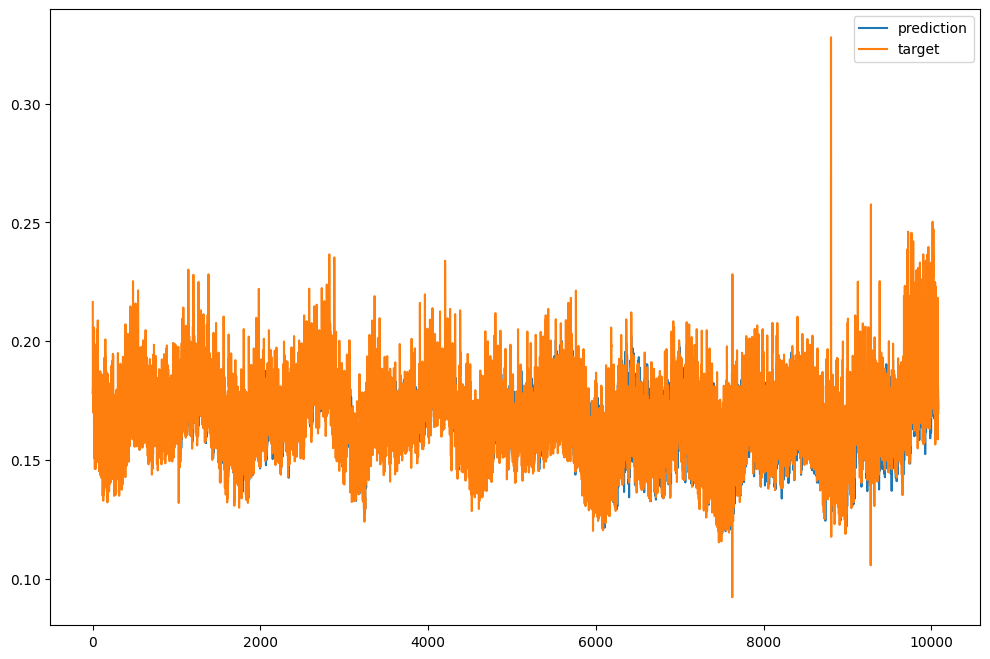

In [82]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [83]:
np.array(pred_list)

array([0.17816322, 0.17981234, 0.18106517, ..., 0.180852  , 0.17556643,
       0.17147261])

In [84]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [85]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [86]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

3.827524185180664 %


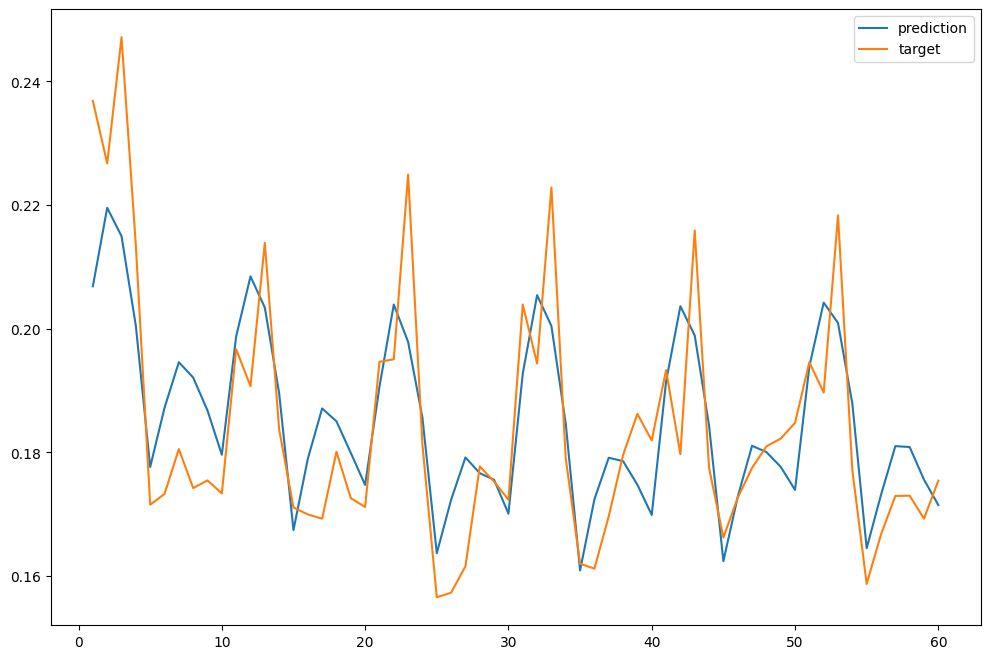

In [87]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [88]:
len(time_list)

10080

In [89]:
np.mean(time_list) 

0.28971698863638773

<font color = blue><font size = 6> Conclusion </font></font><br>
훈련을 하지 않았을때는 8퍼센트의 결과를 보였고 이해 비해서 0.3 퍼센트의 결과는 매우 좋은 결과이다 데이터의 의존성이 큰 DLinear,NLinear등은 이러한 결과가 변동성이 큰 데이터에서도 똑같이 적용될 것이라고 생각된다